# Deep Crossentropy Method for MountainCar

In this notebook we're going to try and achieve an average reward of at lest -150 for MountainCar.

The code has been copied from the deep_crossentropy_method notebook and slightly adapted to the problem.

In [297]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [298]:
# Install gymnasium if you didn't
!pip install gymnasium[toy_text,classic_control]

state vector dim = 2
n_actions = 3


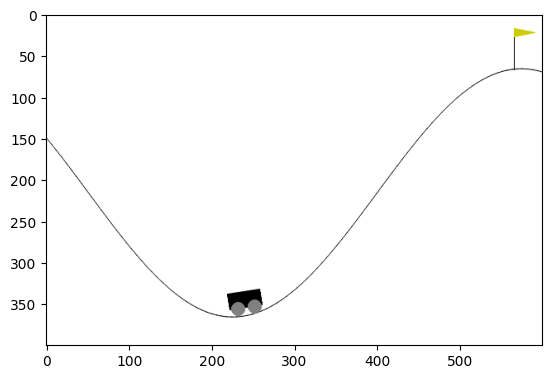

In [299]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("MountainCar-v0", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions) # Accelerate to the left,
                                # Don't accelerate,
                                # Accelerate to the right. 

env.close()

In [300]:
class SessionBuffer():
    """
    This is our simple implementation of a buffer that stores the last
    n_sessions. From the sessions that we store we can then choose the
    percentile of elites over those instead of only the last session.
    """
    def __init__(self, n_sessions, session_size):
        self.n_sessions = n_sessions # How much backlog we want
        self.session_size = session_size # How many samples are in one session
        self.max_length = self.n_sessions * self.session_size
        self.states_buffer = np.empty(shape=(self.max_length,), dtype=list)
        self.actions_buffer = np.empty(shape=(self.max_length,), dtype=list)
        self.rewards_buffer = np.empty(shape=(self.max_length,), dtype=int)
        self.idx = 0

    def store(self, states, actions, reward):
        self.states_buffer[self.idx] = states
        self.actions_buffer[self.idx] = actions
        self.rewards_buffer[self.idx] = reward

        self.idx += 1
        self.idx = self.idx % self.max_length

        assert len(self.states_buffer) <= self.max_length, f"Too many items in buffer: {len(self.states_buffer)}, while {self.max_length} should be maximum" 

    def select_elites(self, percentile=50):
        """
        Select states and actions from games that have rewards >= percentile
        :param states_batch: list of lists of states, states_batch[session_i][t]
        :param actions_batch: list of lists of actions, actions_batch[session_i][t]
        :param rewards_batch: list of rewards, rewards_batch[session_i]
    
        :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
        Please return elite states and actions in their original order
        [i.e. sorted by session number and timestep within session]
    
        If you are confused, see examples below. Please don't assume that states are integers
        (they will become different later).
        """
        assert len(self.states_buffer) != 0, "Empty states_buffer"
        assert len(self.actions_buffer) != 0, "Empty actions_buffer"
        assert len(self.rewards_buffer) != 0, "Empty rewards_buffer"
        
        # compute minimum reward for elite sessions. Hint: use np.percentile()
        # compute minimum reward for elite sessions. Hint: use np.percentile()
        reward_threshold = np.percentile(rewards_batch, percentile)
    
        # Now we just have to return those states and actions which lead to a
        # reward above the threshold
        idx = np.where(self.rewards_buffer >= reward_threshold)[0]
        elite_states = [state for i in idx for state in self.states_buffer[i]]
        elite_actions = [action for i in idx for action in self.actions_buffer[i]]
    
        assert len(elite_states) != 0, "Empty elite_states"
        assert len(elite_actions) != 0, "Empty elite_actions"
        
        return elite_states, elite_actions

    def __len__(self):
        return len(self.states_buffer)

### Neural Network Policy

In [301]:
from sklearn.neural_network import MLPClassifier

hidden_layer_1 = 64
hidden_layer_2 = 64

agent = MLPClassifier(
    hidden_layer_sizes=(hidden_layer_1, hidden_layer_2),
    activation="tanh",
)

X = [env.reset()[0]] * n_actions # {array-like, sparse matrix} of shape (n_samples, n_features)
y = range(n_actions)             # array-like of shape (n_samples,)

# This means that we need X.shape[0] == Y.shape[0]

# initialize agent to the dimension of state space and number of actions
agent.partial_fit(X, y, classes=range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(64, 64))

In [302]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps

    :returns: 
        states: list of numpy.ndarray
        actions: list of int
        total_reward: int  
    """
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()

    for t in range(t_max):

        # use agent to predict a vector of action probabilities for state :s:        
        probs = agent.predict_proba([s] * n_actions)[0]
        
        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(n_actions, p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, terminated, truncated, _ = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward

In [303]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print(type(dummy_states))
print(type(dummy_states[0]))
print("actions:", dummy_actions)
print(type(dummy_actions))
print(type(dummy_actions[0]))
print("reward:", dummy_reward)

states: [[-4.9130425e-01  0.0000000e+00]
 [-4.9154606e-01 -2.4183025e-04]
 [-4.9202794e-01 -4.8185521e-04]
 [-4.9174622e-01  2.8171731e-04]
 [-4.9070302e-01  1.0431865e-03]]
<class 'list'>
<class 'numpy.ndarray'>
actions: [1, 1, 2, 2, 2]
<class 'list'>
<class 'int'>
reward: -5.0


### CEM Steps

In [304]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """
    assert len(states_batch) != 0, "Empty states_batch"
    assert len(actions_batch) != 0, "Empty actions_batch"
    assert len(rewards_batch) != 0, "Empty rewards_batch"
    
    # compute minimum reward for elite sessions. Hint: use np.percentile()
    reward_threshold = np.percentile(rewards_batch, percentile)

    # Now we just have to return those states and actions which lead to a
    # reward above the threshold
    idx = np.where(rewards_batch >= reward_threshold)[0]
    print(idx)
    elite_states = [state for i in idx for state in states_batch[i]]
    elite_actions = [action for i in idx for action in actions_batch[i]]

    assert len(elite_states) != 0, "Empty elite_states"
    assert len(elite_actions) != 0, "Empty elite_actions"
    
    return elite_states, elite_actions

### Training Loop

In [305]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, n_sessions, reward_range=[-990, +10], last_iter=False):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    if last_iter:
        plt.savefig(f"./logs/mountaincar-v3_{hidden_layer_1}_{hidden_layer_2}_{n_sessions}_{percentile}_{-reward_range[0]}.png")
    plt.show()

In [312]:
def train_w_buffer(episodes, n_sessions, max_steps, percentile, log, buffer, experience_collection):
    # TODO: Fix. Doesn't really work.
    # - Does it even make sense to just store all experiences willy nilly in a buffer?
    # - Shouldn't we just keep the best experiences from one iteration?
    for i in range(episodes):
        # generate new sessions
        for _ in range(n_sessions):
            states, actions, reward = generate_session(env, agent, t_max=max_steps)
            buffer.store(states, actions, reward)

        if i >= experience_collection:
            elite_states, elite_actions = buffer.select_elites(percentile)
        
            agent.partial_fit(elite_states_old, elite_actions_old)
        
            if i == 99:
                show_progress(
                    buffer.rewards_buffer[-n_sessions:], log, percentile, n_sessions, 
                    reward_range=[-max_steps, np.max(rewards_batch)], 
                    last_iter=True
                )
            else:
                show_progress(
                    buffer.rewards_buffer[-n_sessions:], log, percentile, n_sessions, 
                    reward_range=[-max_steps, np.max(rewards_batch)]
                )
        print(f"Episode: {i+1}")

In [313]:
def train(episodes, n_sessions, max_steps, percentile, log):
    for i in range(episodes):
        # generate new sessions
        sessions = [generate_session(env, agent, t_max=max_steps) for _ in range(n_sessions)]
        
        states_batch, actions_batch, rewards_batch = zip(*sessions)
    
        elite_states_old, elite_actions_old = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
        agent.partial_fit(elite_states_old, elite_actions_old)
    
        if i == 99:
            show_progress(
                rewards_batch, log, percentile, n_sessions, reward_range=[-max_steps, np.max(rewards_batch)], last_iter=True
            )
        else:
            show_progress(
                rewards_batch, log, percentile, n_sessions, reward_range=[-max_steps, np.max(rewards_batch)]
            )
        print(f"Episode: {i+1}")
    
        if np.mean(rewards_batch) > -100:
            print("You Win! You may stop training now via KeyboardInterrupt.")

In [ ]:
episodes = 100
n_sessions = 100
percentile = 25
log = []
max_steps = 10_000
experience_collection = 3 # How many episodes we collect experiences
buffer = SessionBuffer(experience_collection, n_sessions)

train(episodes, n_sessions, max_steps, percentile, log)
#train_w_buffer(episodes, n_sessions, max_steps, percentile, log, buffer, experience_collection)

In [ ]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)

    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = (
        agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)
    )

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(
        probs,
        extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed),
        aspect="auto",
    )
    ax.set_title("Learned policy: red=left, green=nothing, blue=right")
    ax.set_xlabel("position (x)")
    ax.set_ylabel("velocity (v)")

    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color="white")

    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color="white", head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color="white", head_length=0.02)


with gym.make("MountainCar-v0", render_mode="rgb_arrary").env as env:
    visualize_mountain_car(env, agent)

In [ ]:
# Record sessions

from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("MountainCar-v0", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]


In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)